# Import Libraries

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import optuna
from catboost import CatBoostClassifier, Pool, cv

import datetime

Basic settings. They improve the visual appearance of charts and hide unnecessary logs and warnings.

In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,)

plt.rcParams.update({'lines.linewidth': 1.25,
                     'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 6)})

%config InlineBackend.figure_format = 'retina'

Function for displaying cross-validation results. Additionally returns best_iter, which will be required to predict the target on the test set.

In [3]:
def print_cv_summary(cv_data):
    best_value = cv_data['test-Logloss-mean'].min()
    best_iter = cv_data['test-Logloss-mean'].values.argmin()

    print('Best validation Logloss score : {:.3f}±{:.3f} on step {}'.format(
        best_value,
        cv_data['test-Logloss-std'][best_iter],
        best_iter)
    )
    
    return best_iter

# Extract Transform Load (ETL)

Load and merge dataframes.

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape, test.shape)

(8693, 14) (4277, 13)


In [5]:
df = pd.concat([train, test],
               ignore_index=True,
               axis=0).reset_index(drop=True)
df.head(20)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000,False,0.000,0.000,0.000,0.000,0.000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000,False,109.000,9.000,25.000,549.000,44.000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000,True,43.000,3576.000,0.000,6715.000,49.000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000,False,0.000,1283.000,371.000,3329.000,193.000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000,False,303.000,70.000,151.000,565.000,2.000,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.000,False,0.000,483.000,0.000,291.000,0.000,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.000,False,42.000,1539.000,3.000,0.000,0.000,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.000,False,0.000,0.000,0.000,0.000,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.000,False,0.000,785.000,17.000,216.000,0.000,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.000,False,0.000,0.000,0.000,0.000,0.000,Erraiam Flatic,True


# Exploratory Data Analysis (EDA)

First of all, let's evaluate the balance of classes. The classes are well balanced, we will assume the same picture is observed in the test dataframe.

In [6]:
train.Transported.value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

Let's use pandas_profiling to get some basic information about our data.

In [ ]:
profile.to_html

In [7]:
profile = pandas_profiling.ProfileReport(df, title='Pandas Profiling Report', dark_mode=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

It follows from the report that there are few NaN, but they are scattered around. 

CryoSleep is most associated with the target variable.

Conclusions by age were confirmed, the distribution turned out to be strange (why are there so many children on the ship?), but it is not worth correcting the data.

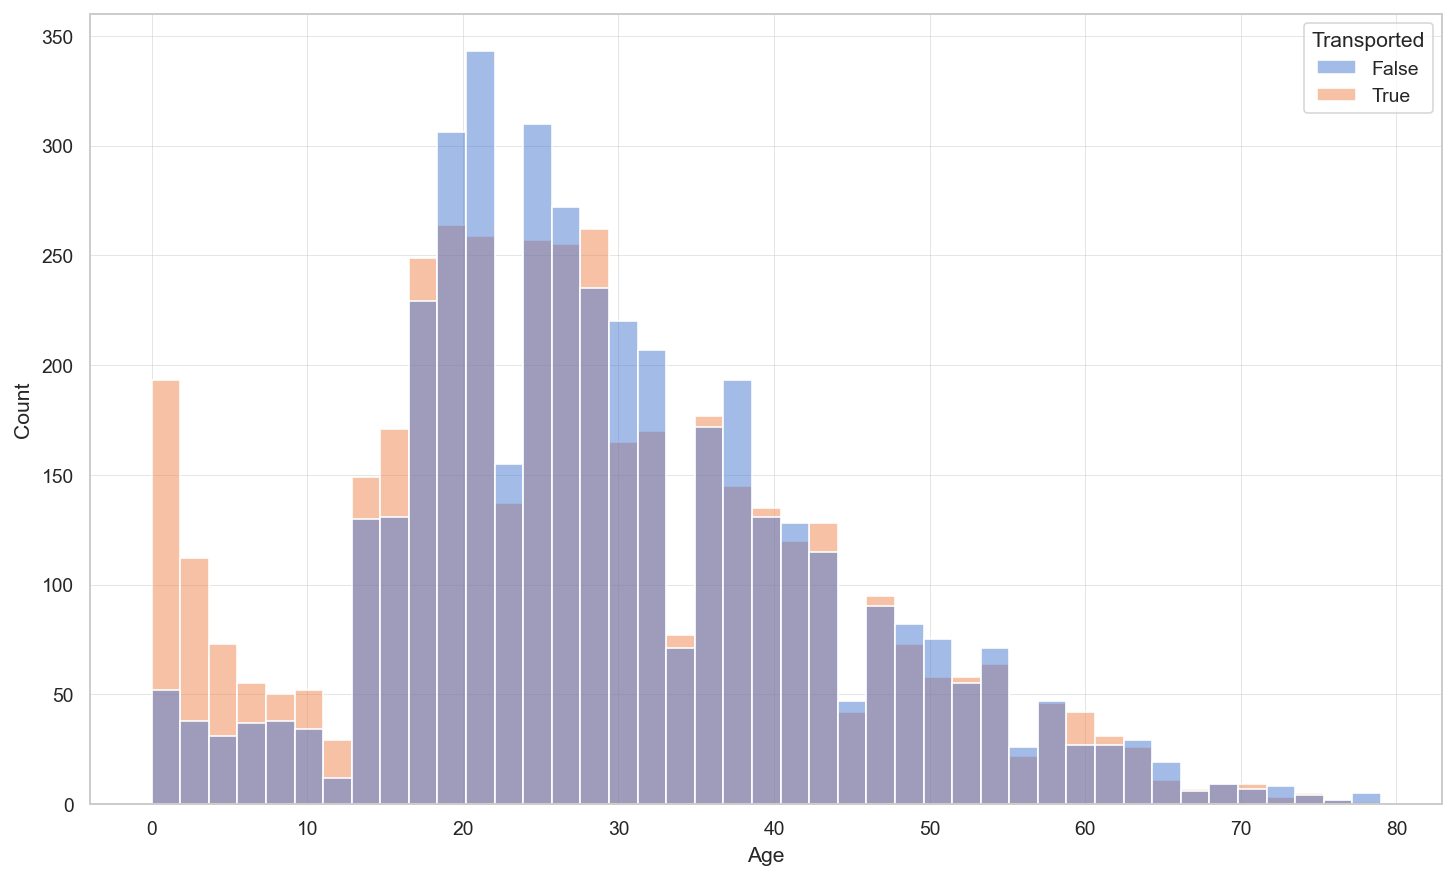

In [8]:
sns.histplot(data=train, x='Age', hue='Transported');

There are quite a lot of outliers in spending, for better visualization we use the np.log1p function to the data. The impact of spending on the target variable is now clearly visible.

Excluding missings variables, most of those who didn't transported spent less money.

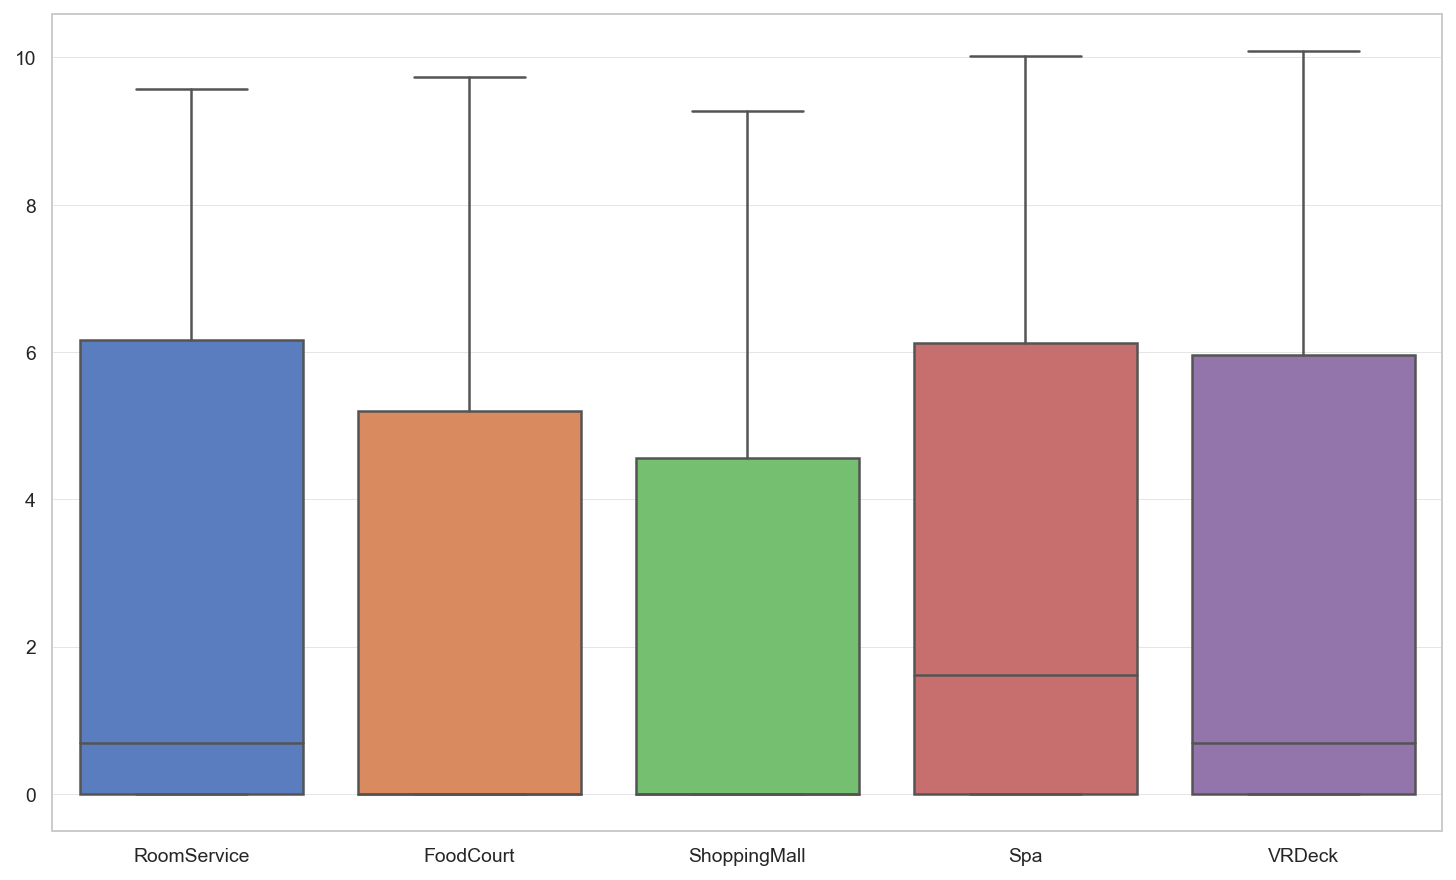

In [9]:
sns.boxplot(data=train
            .query('Transported == False')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
            .apply(np.log1p));

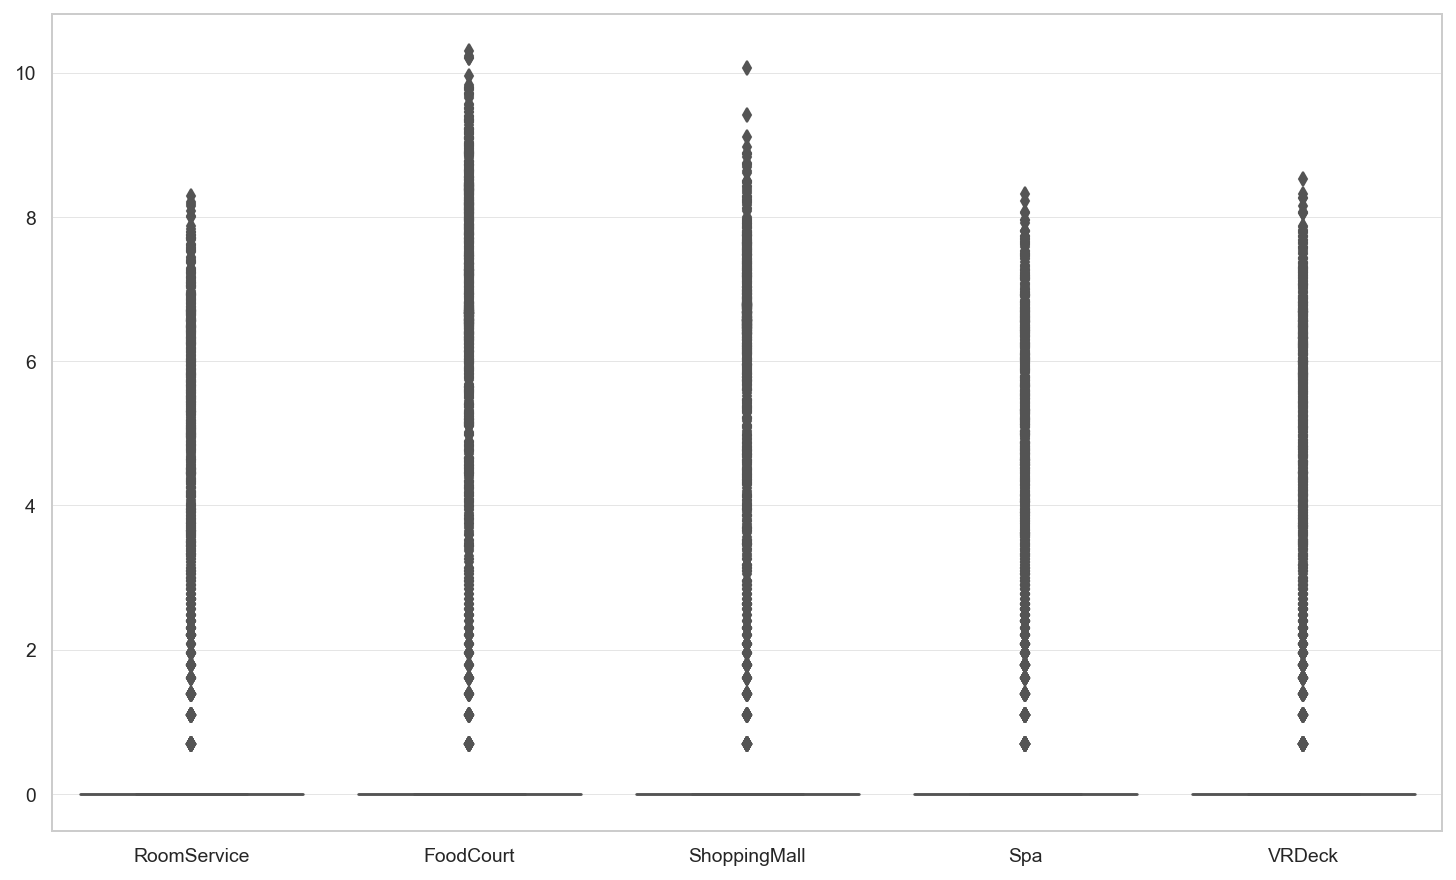

In [10]:
sns.boxplot(data=train
            .query('Transported == True')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
            .apply(np.log1p));

If CryoSleep == True, then there are no expenses, which is logical.

In [11]:
df[df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1) > 0].query('CryoSleep == True')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported


Age is also associated with spending.

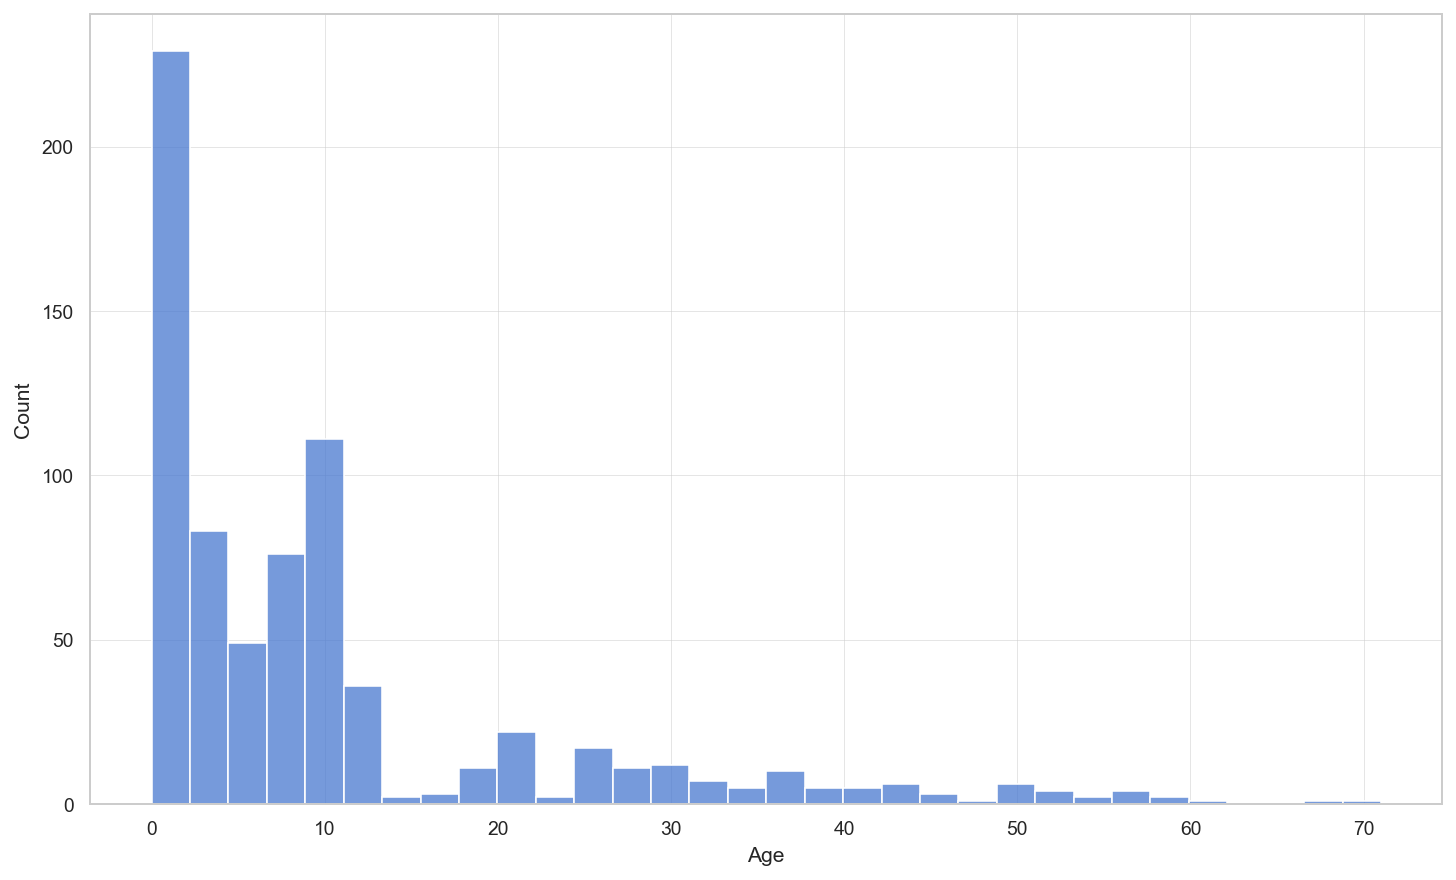

In [12]:
sns.histplot(
    data=df[df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1) == 0].query('CryoSleep == False').Age
);

# Conclusions:

* PassengerId contains a number after the '_' which may indicate a group. For people with the same last name, id increases. Logically, the survival rate of singles should be different from those who flew in a group.
* The total expenditure should be added.

# Models

Let's create a FeatureTransformer that will transform the data before sending it to the model.

In [13]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Make a copy() to not change the data in the main dataframe.
        X = X.copy()
        
        # Unpack the data by creating additional features.
        X[['cab_1', 'cab_2', 'cab_3']] = X.Cabin.str.split('/', expand=True)
        X['cab_2'] = X.cab_2.astype(float)
        X[['party_n', 'party_count']] = X.PassengerId.str.split('_', expand=True)
        X['party_n'] = X.party_n.astype(int)
        
        # Assume that the passes in VIP are predominantly True.
        X['VIP'] = X.VIP.fillna(True)
        
        # Сalculate the total cost.
        X['expenditure'] = X[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
        
        # Costs are zero if the passenger is in cryosleep.
        X['CryoSleep'] = X.CryoSleep.fillna(X.expenditure.apply(lambda x: 'no' if x != 0 else np.nan))
        
        # We use IterativeImputer to fill gaps in quantitative data.
        imp_median = IterativeImputer(initial_strategy='median', random_state=38)
        X[['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = \
            imp_median.fit_transform(X[['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']])

        # In order to avoid errors, we need to convert the boolean type to strings, otherwise with the addition of 'unknown' there will be a non-working mix.
        X['CryoSleep'] = X.CryoSleep.replace(True, 'yes').replace(False, 'no')
        X['VIP'] = X.VIP.replace(True, 'yes').replace(False, 'no')
        
        # Let's remove the useless data.
        X.drop(columns=['PassengerId', 'Name', 'Cabin', 'party_count'], inplace=True)
        
        # Fill in the categories with gaps - 'unknown'.
        cols = X.select_dtypes(exclude=np.number).columns.tolist()
        X[cols] = X[cols].fillna('unknown')
        X[cols] = X[cols].apply(lambda x: x.astype('category'))
        
        return X

Now, we select the target variable and break down the data, after that we form a pool for CatBoost.

In [14]:
X = train.drop('Transported', axis=1)
X = FeatureTransformer().transform(X)
y = train.loc[X.index, 'Transported'] * 1

cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
full_data = Pool(X, y, cat_features)

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=0.2, random_state=38)

train_data = Pool(X_train, y_train, cat_features)
valid_data = Pool(X_valid, y_valid, cat_features)

Let's run optuna and select the optimal hyperparameters.

In [15]:
def objective(trial: optuna.Trial) -> float:
    
    # Model parameters.
    params = {
        'objective': 'Logloss',
        'loss_function': 'Logloss',
        'depth': trial.suggest_int('depth', 5, 6),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.8, 1, log=True),
        'random_strength': trial.suggest_float("random_strength", 0.2, 1, log=False),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 20, 48, 4),
        'iterations': 1250,
    }

    gbm = CatBoostClassifier(**params)
    gbm.fit(
        train_data,
        eval_set=valid_data,
        verbose=0,
        early_stopping_rounds=100,
    )
    
    #Usually y_test is used, but I did not want to further split the sample.
    y_hat = gbm.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_hat)

    return accuracy

In [ ]:
study = optuna.create_study(
        study_name='Hyperparameters tuning',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
        direction="maximize"
)
study.optimize(objective, n_trials=200)

print(f'Research completed! Best result: {study.best_value:.4f}')

Let's write down the main parameters and supplement them with best_params from the opuna through the update function.

In [16]:
params = {
    'objective': 'Logloss',
    'loss_function': 'Logloss',
    'iterations': 1250,
    'random_seed': 38,
    }

# Options to not restart Optuna.
study_best_params = {'depth': 5,
                     'colsample_bylevel': 0.900649945039171,
                     'random_strength': 0.5477373944761731,
                     'min_data_in_leaf': 20}

try:
    params.update(study.best_params)
except:
    params.update(study_best_params)

Let's check what results the CV will give before predict the test target.

In [17]:
cv_data = cv(
    pool=full_data,
    params=params,
    early_stopping_rounds=100,
    verbose=250,
    fold_count=5,
    partition_random_seed=38)

best_iter = print_cv_summary(cv_data)

Training on fold [0/5]
0:	learn: 0.6817594	test: 0.6819760	best: 0.6819760 (0)	total: 183ms	remaining: 3m 48s
250:	learn: 0.3792542	test: 0.3930847	best: 0.3930847 (250)	total: 5.38s	remaining: 21.4s
500:	learn: 0.3482243	test: 0.3798407	best: 0.3798407 (500)	total: 10.3s	remaining: 15.4s
750:	learn: 0.3252928	test: 0.3760200	best: 0.3759465 (738)	total: 15.2s	remaining: 10.1s
1000:	learn: 0.3066977	test: 0.3723857	best: 0.3723727 (995)	total: 20.1s	remaining: 5s
1249:	learn: 0.2897972	test: 0.3710812	best: 0.3707800 (1216)	total: 25.2s	remaining: 0us

bestTest = 0.3707799666
bestIteration = 1216

Training on fold [1/5]
0:	learn: 0.6811265	test: 0.6816867	best: 0.6816867 (0)	total: 19ms	remaining: 23.7s
250:	learn: 0.3790548	test: 0.3921029	best: 0.3921029 (250)	total: 5.02s	remaining: 20s
500:	learn: 0.3493820	test: 0.3799736	best: 0.3799556 (499)	total: 9.87s	remaining: 14.8s
750:	learn: 0.3253733	test: 0.3740477	best: 0.3739598 (744)	total: 14.9s	remaining: 9.87s
1000:	learn: 0.3064

We disable use_best_model since we no longer have an eval_set and predict the target on the test.

In [18]:
params.update({'iterations': best_iter,
               'use_best_model': False})

gbm = CatBoostClassifier(**params)
gbm.fit(full_data, verbose=0)

y_hat = gbm.predict(FeatureTransformer().transform(test))
# The task requires a result with a boolean type, so we additionally process the predictions.
y_hat = list(map(lambda x: x > 0.5, y_hat))

# Combine PassengerId and predictions.
res = pd.concat([test.PassengerId,
                 pd.Series(y_hat, index=test.index, name='Transported')],
                axis=1)

# Save the result.
file_name = 'Prediction-' + str(datetime.date.today()) + '.csv'
pd.DataFrame(res).to_csv(file_name, index=False)
print('Saved!')

Saved!


# Final Conclusions:

* The model formed and good accuracy achieved.